In [10]:
### Load neccessary libraries
import subprocess
import numpy as np
import iris
import sys
import matplotlib.pyplot as plt
sys.path.append('/usr/people/thompson/WP1/boosting')
import functions_boosting as gboost
sys.path.append('/usr/people/thompson/WP1')
import functions_get_data as gdata
import functions_plot_data as pdata
import iris.coord_categorisation as icc
from iris.coord_categorisation import add_season_membership
import matplotlib.pyplot as plt
import iris.plot as iplt
import cartopy.crs as ccrs
import cartopy as cart
import glob
import matplotlib.cm as mpl_cm
import sys
import scipy.stats as sps
from scipy.stats import genextreme as gev
import random
import scipy.io
import xarray as xr
import netCDF4 as nc
import iris.coords
import iris.util
from iris.util import equalise_attributes
from iris.util import unify_time_units
from scipy.stats.stats import pearsonr
import calendar
import cartopy.feature as cf
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
plt.ion(); plt.show()
from mpl_toolkits.basemap import Basemap, shiftgrid, cm
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as c
from matplotlib.transforms import offset_copy
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings("ignore")

rivers_10m = c.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m')

In [11]:
## Variables
R1 = [70, 30, 30, -30] # analog region
date = [2021, 'Jul', 14] # event date

## Inputs
plotdate = '20070825' # '20090829' '20160801'
rain_region = [55, 45, 15, 0]


In [12]:
## Some example extremes
def plot_prec(axs, startdate, plotdate, region, ens=0):
    '''
    For a selected initialisation date (startdate) and individual date (plotdate)
    Plots precip field with Z500 overlaid
    startdate: str, format YYYYMMDD
    plotdate: str, format YYYYMMDD
    region: region shown in plot, format [N, S, W, E]
    ens: ensemble number, 0-49, default=0
    '''
    ## Get TP cube
    TP_cube = gboost.get_TP_cube(startdate, plotdate, region, ens)
    # plot data
    lats=TP_cube.coord('latitude').points
    lons=TP_cube.coord('longitude').points
    c = axs.contourf(lons, lats, TP_cube.data, levels=np.linspace(1, 50, 10), cmap = plt.cm.get_cmap('Blues'), transform=ccrs.PlateCarree(), extend='both')
    axs.set_ylim([45, 55])
    axs.set_xlim([2,12]) 
    return

## Some example extremes
def plot_prec_mesh(axs, startdate, plotdate, region, ens=0):
    '''
    For a selected initialisation date (startdate) and individual date (plotdate)
    Plots precip field with Z500 overlaid
    startdate: str, format YYYYMMDD
    plotdate: str, format YYYYMMDD
    region: region shown in plot, format [N, S, W, E]
    ens: ensemble number, 0-49, default=0
    '''
    ## Get TP cube
    TP_cube = gboost.get_TP_cube(startdate, plotdate, region, ens)
    # plot data
    lats=TP_cube.coord('latitude').points
    lons=TP_cube.coord('longitude').points
    c = axs.pcolormesh(lons, lats, TP_cube.data, vmin=1, vmax=80, cmap = plt.cm.get_cmap('Blues'), transform=ccrs.PlateCarree())
    axs.set_ylim([45, 55])
    axs.set_xlim([2,12]) 
    return




In [24]:

def add_cities(ax):
    irish_towns = {
        'Dortmond': {'lon': 7.4653, 'lat': 51.5136, 'x_off': 2, 'y_off': 3, 'v_al': 'bottom', 'h_al': 'left'},
        'Brussels': {'lon': 4.3572, 'lat': 50.8476, 'x_off': -3, 'y_off': -4, 'v_al': 'top', 'h_al': 'center'},
        'Cologne': {'lon': 6.9603, 'lat': 50.9375, 'x_off': -3, 'y_off': -4, 'v_al': 'top', 'h_al': 'left'},
        'Amsterdam': {'lon': 4.9041, 'lat': 52.3676, 'x_off': 2, 'y_off': 3, 'v_al': 'bottom', 'h_al': 'center'},
        'Strasbourg': {'lon': 7.7521, 'lat': 48.5734, 'x_off': -3, 'y_off': -4, 'v_al': 'top', 'h_al': 'left'},
        'Paris': {'lon': 2.3514, 'lat': 48.8575, 'x_off': -3, 'y_off': -4, 'v_al': 'top', 'h_al': 'left'},
        'Luxembourg': {'lon': 6.1319, 'lat': 49.6116, 'x_off': -3, 'y_off': -4, 'v_al': 'top', 'h_al': 'left'}
        }
    geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)
    for name, data in irish_towns.items():
        text_transform = offset_copy(geodetic_transform, units='dots', x=data['x_off'], y=data['y_off'])
        ax.plot(data['lon'], data['lat'], marker='o', markersize=5, color='r', markeredgecolor='black', alpha=0.8, transform=ccrs.Geodetic())
        ax.text(data['lon'], data['lat'], name, color='chocolate', fontsize=10,
            verticalalignment=data['v_al'],
            horizontalalignment=data['h_al'],
            transform=text_transform)
        
def add_river(ax):
    ax.add_feature(rivers_10m, facecolor='None', edgecolor='cyan')


def add_basin(ax):
    In_st_shp = 'basins/hybas_eu_lev05_v1c.shp'
    state_feature = ShapelyFeature(Reader(In_st_shp).geometries(),
                               crs=ccrs.PlateCarree(), edgecolor='r')
    ax.add_feature(state_feature, edgecolor="k", linewidth=.5, facecolor='None')

def add_topo(ax):
    # read in etopo5 topography/bathymetry.
    url = 'http://ferret.pmel.noaa.gov/thredds/dodsC/data/PMEL/etopo5.nc'
    etopodata = Dataset(url)
    topoin = etopodata.variables['ROSE'][:]
    lons = etopodata.variables['ETOPO05_X'][:]
    lats = etopodata.variables['ETOPO05_Y'][:]
    # shift data so lons go from -180 to 180 instead of 20 to 380.
    topoin,lons = shiftgrid(180.,topoin,lons,start=False)
    im = ax.imshow(topoin)
    
    
def background(ax):
    ax.coastlines(linewidth=0.4)
    #ax.add_feature(cf.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)
    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, linewidth=0.2, color='k',alpha=0.5,linestyle='--')
    gl.right_labels = gl.top_labels = False
    gl.xlabel_style = {'size': 5, 'color': 'gray'}
    gl.ylabel_style = {'size': 5, 'color': 'gray'}
    ax.add_feature(cf.BORDERS, color='grey', linewidth=.5)
    ax.add_feature(cf.COASTLINE, color='grey', linewidth=.5)
    ax.set_xticks([-5, 0, 5, 10, 15, 20], crs=ccrs.PlateCarree())
    ax.set_yticks([45, 47.5, 50, 52.5, 55], crs=ccrs.PlateCarree())
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(color='lightgrey')


2021
0
2021


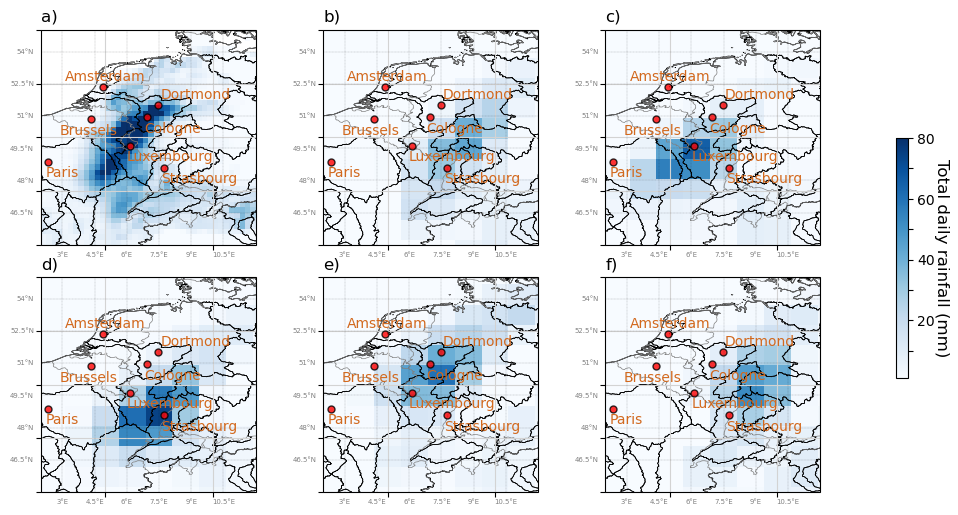

In [27]:
fig, axs = plt.subplots(nrows=2, ncols=3, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12,6))

# Observed event
event_z500 = gdata.var_event_data('z500', R1, date)


file = '/net/pc230042/nobackup_1/users/sager/ClimateExplorer/sandbox/ENSEMBLES/rr_0.25deg_reg_v30.0eu.nc'
eobs_cube = iris.load(file)[0]
iris.coord_categorisation.add_year(eobs_cube, 'time')
iris.coord_categorisation.add_season(eobs_cube, 'time')
iris.coord_categorisation.add_day_of_year(eobs_cube, 'time')
eobs_cube = eobs_cube.extract(iris.Constraint(season='jja'))
eobs_cube = eobs_cube.extract(iris.Constraint(year=2021))
eobs_cube = eobs_cube.extract(iris.Constraint(day_of_year=195))
lat_con = iris.Constraint(latitude=lambda cell: 40 < cell < 60)
lon_con = iris.Constraint(longitude=lambda cell: -10 < cell < 20)
event_prec = eobs_cube.extract(lat_con&lon_con)
lats=event_prec.coord('latitude').points
lons=event_prec.coord('longitude').points

c = axs[0,0].pcolormesh(lons, lats, event_prec.data, vmin=1, vmax=80, cmap = plt.cm.get_cmap('Blues'), transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.3, 0.01, 0.4])
fig.colorbar(c, cax=cbar_ax, ticks=np.arange(0, 100, 10))
cbar_ax.set_ylabel('Total daily rainfall (mm)', labelpad=10, rotation=270, fontsize=12)
cbar_ax.set_yticklabels(['0', '', '20','','40','','60','','80',''])

axs[0,0].set_ylim([45, 55])
axs[0,0].set_xlim([2,12]) 

for ax in axs.reshape(-1):
    #add_topo(ax)
    add_basin(ax)

plot_prec_mesh(axs[0,1], str(20070816), str(20070825), R1, 3)
plot_prec_mesh(axs[0,2], str(20070816), str(20070825), R1, 16)
plot_prec_mesh(axs[1,0], str(20070814), str(20070825), R1, 25)
plot_prec_mesh(axs[1,1], str(20070815), str(20070825), R1, 21)
plot_prec_mesh(axs[1,2], str(20070814), str(20070825), R1, 1)

axs[0,0].set_title('a)', loc='left')
axs[0,1].set_title('b)', loc='left')
axs[0,2].set_title('c)', loc='left')
axs[1,0].set_title('d)', loc='left')
axs[1,1].set_title('e)', loc='left')
axs[1,2].set_title('f)', loc='left')

for ax in axs.reshape(-1):
    add_cities(ax)
    background(ax)
    ax.set_ylim([45, 55])
    ax.set_xlim([2,12]) 

plt.subplots_adjust(wspace=.15, hspace = 0.15)

plt.savefig('ThompsonBoosting_Fig6.png', dpi=80)

2021
0
2021


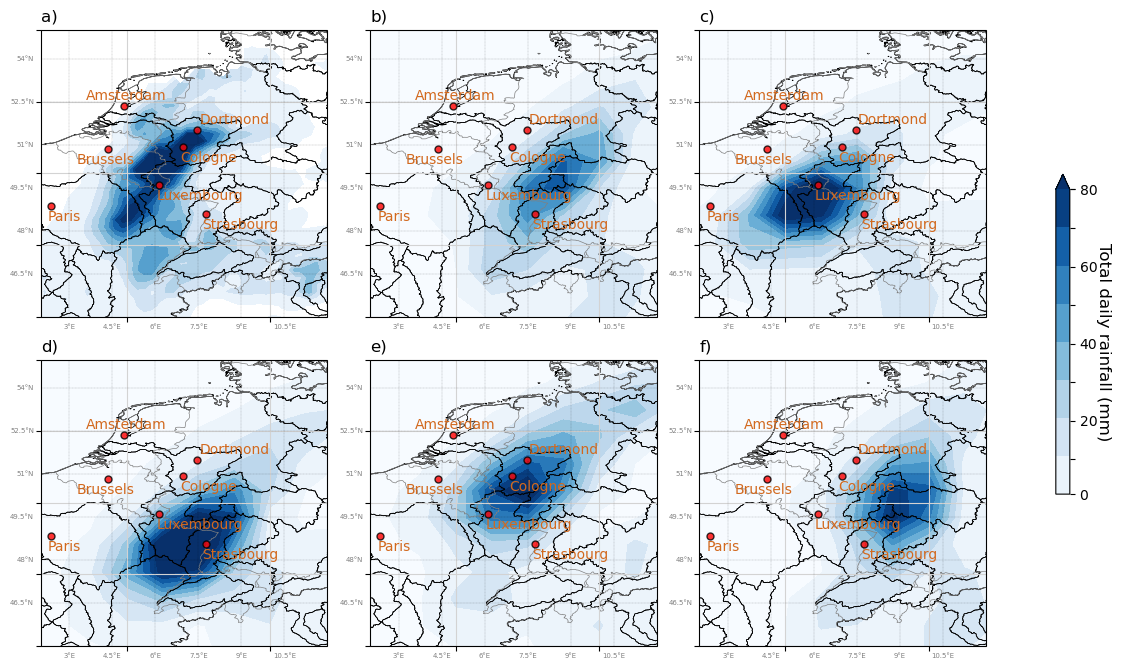

In [26]:
fig, axs = plt.subplots(nrows=2, ncols=3, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(14,8))

# Observed event
event_z500 = gdata.var_event_data('z500', R1, date)
file = '/net/pc230042/nobackup_1/users/sager/ClimateExplorer/sandbox/ENSEMBLES/rr_0.25deg_reg_v30.0eu.nc'
eobs_cube = iris.load(file)[0]
iris.coord_categorisation.add_year(eobs_cube, 'time')
iris.coord_categorisation.add_season(eobs_cube, 'time')
iris.coord_categorisation.add_day_of_year(eobs_cube, 'time')
eobs_cube = eobs_cube.extract(iris.Constraint(season='jja'))
eobs_cube = eobs_cube.extract(iris.Constraint(year=2021))
eobs_cube = eobs_cube.extract(iris.Constraint(day_of_year=195))
lat_con = iris.Constraint(latitude=lambda cell: 40 < cell < 60)
lon_con = iris.Constraint(longitude=lambda cell: -10 < cell < 20)
event_prec = eobs_cube.extract(lat_con&lon_con)
lats=event_prec.coord('latitude').points
lons=event_prec.coord('longitude').points

c = axs[0,0].contourf(lons, lats, event_prec.data, levels=np.linspace(1, 80, 9), cmap = plt.cm.get_cmap('Blues'), transform=ccrs.PlateCarree(), extend='max')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.3, 0.01, 0.4])
fig.colorbar(c, cax=cbar_ax, ticks=np.arange(0, 100, 10))
cbar_ax.set_ylabel('Total daily rainfall (mm)', labelpad=10, rotation=270, fontsize=12)
cbar_ax.set_yticklabels(['0', '', '20','','40','','60','','80',''])

axs[0,0].set_ylim([45, 55])
axs[0,0].set_xlim([2,12]) 

for ax in axs.reshape(-1):
    #add_topo(ax)
    add_basin(ax)

plot_prec(axs[0,1], str(20070816), str(20070825), R1, 3)
plot_prec(axs[0,2], str(20070816), str(20070825), R1, 16)
plot_prec(axs[1,0], str(20070814), str(20070825), R1, 25)
plot_prec(axs[1,1], str(20070815), str(20070825), R1, 21)
plot_prec(axs[1,2], str(20070814), str(20070825), R1, 1)

axs[0,0].set_title('a)', loc='left')
axs[0,1].set_title('b)', loc='left')
axs[0,2].set_title('c)', loc='left')
axs[1,0].set_title('d)', loc='left')
axs[1,1].set_title('e)', loc='left')
axs[1,2].set_title('f)', loc='left')

for ax in axs.reshape(-1):
    add_cities(ax)
    background(ax)
    ax.set_ylim([45, 55])
    ax.set_xlim([2,12]) 

plt.subplots_adjust(wspace=.15, hspace = 0.15)


In [ ]:

plot_prec(axs[0,1], str(20070816), str(20070825), R1, 3)
plot_prec(axs[0,2], str(20070816), str(20070825), R1, 16)
plot_prec(axs[1,0], str(20070814), str(20070825), R1, 25)
plot_prec(axs[1,1], str(20070815), str(20070825), R1, 21)
plot_prec(axs[1,2], str(20070814), str(20070825), R1, 1)

axs[0,0].set_title('a)', loc='left')
axs[0,1].set_title('b)', loc='left')
axs[0,2].set_title('c)', loc='left')
axs[1,0].set_title('d)', loc='left')
axs[1,1].set_title('e)', loc='left')

for ax in axs.reshape(-1):
    add_cities(ax)
    background(ax)
    ax.set_ylim([45, 55])
    ax.set_xlim([2,12]) 

plt.subplots_adjust(wspace=.15, hspace = 0.15)


In [ ]:


plot_prec_z500(axs[0,1], str(20070816), str(20070825), R1, 3)
plot_prec_z500(axs[0,2], str(20070816), str(20070825), R1, 16)
plot_prec_z500(axs[1,0], str(20070814), str(20070825), R1, 25)
plot_prec_z500(axs[1,1], str(20070815), str(20070825), R1, 21)
plot_prec_z500(axs[1,2], str(20070814), str(20070825), R1, 1)

axs[0,0].set_title('a)', loc='left')
axs[0,1].set_title('b)', loc='left')
axs[0,2].set_title('c)', loc='left')
axs[1,0].set_title('d)', loc='left')
axs[1,1].set_title('e)', loc='left')

2021
0
2021
2021
0
2021


ValueError: Axes should be an instance of GeoAxes, got <class 'matplotlib.axes._axes.Axes'>

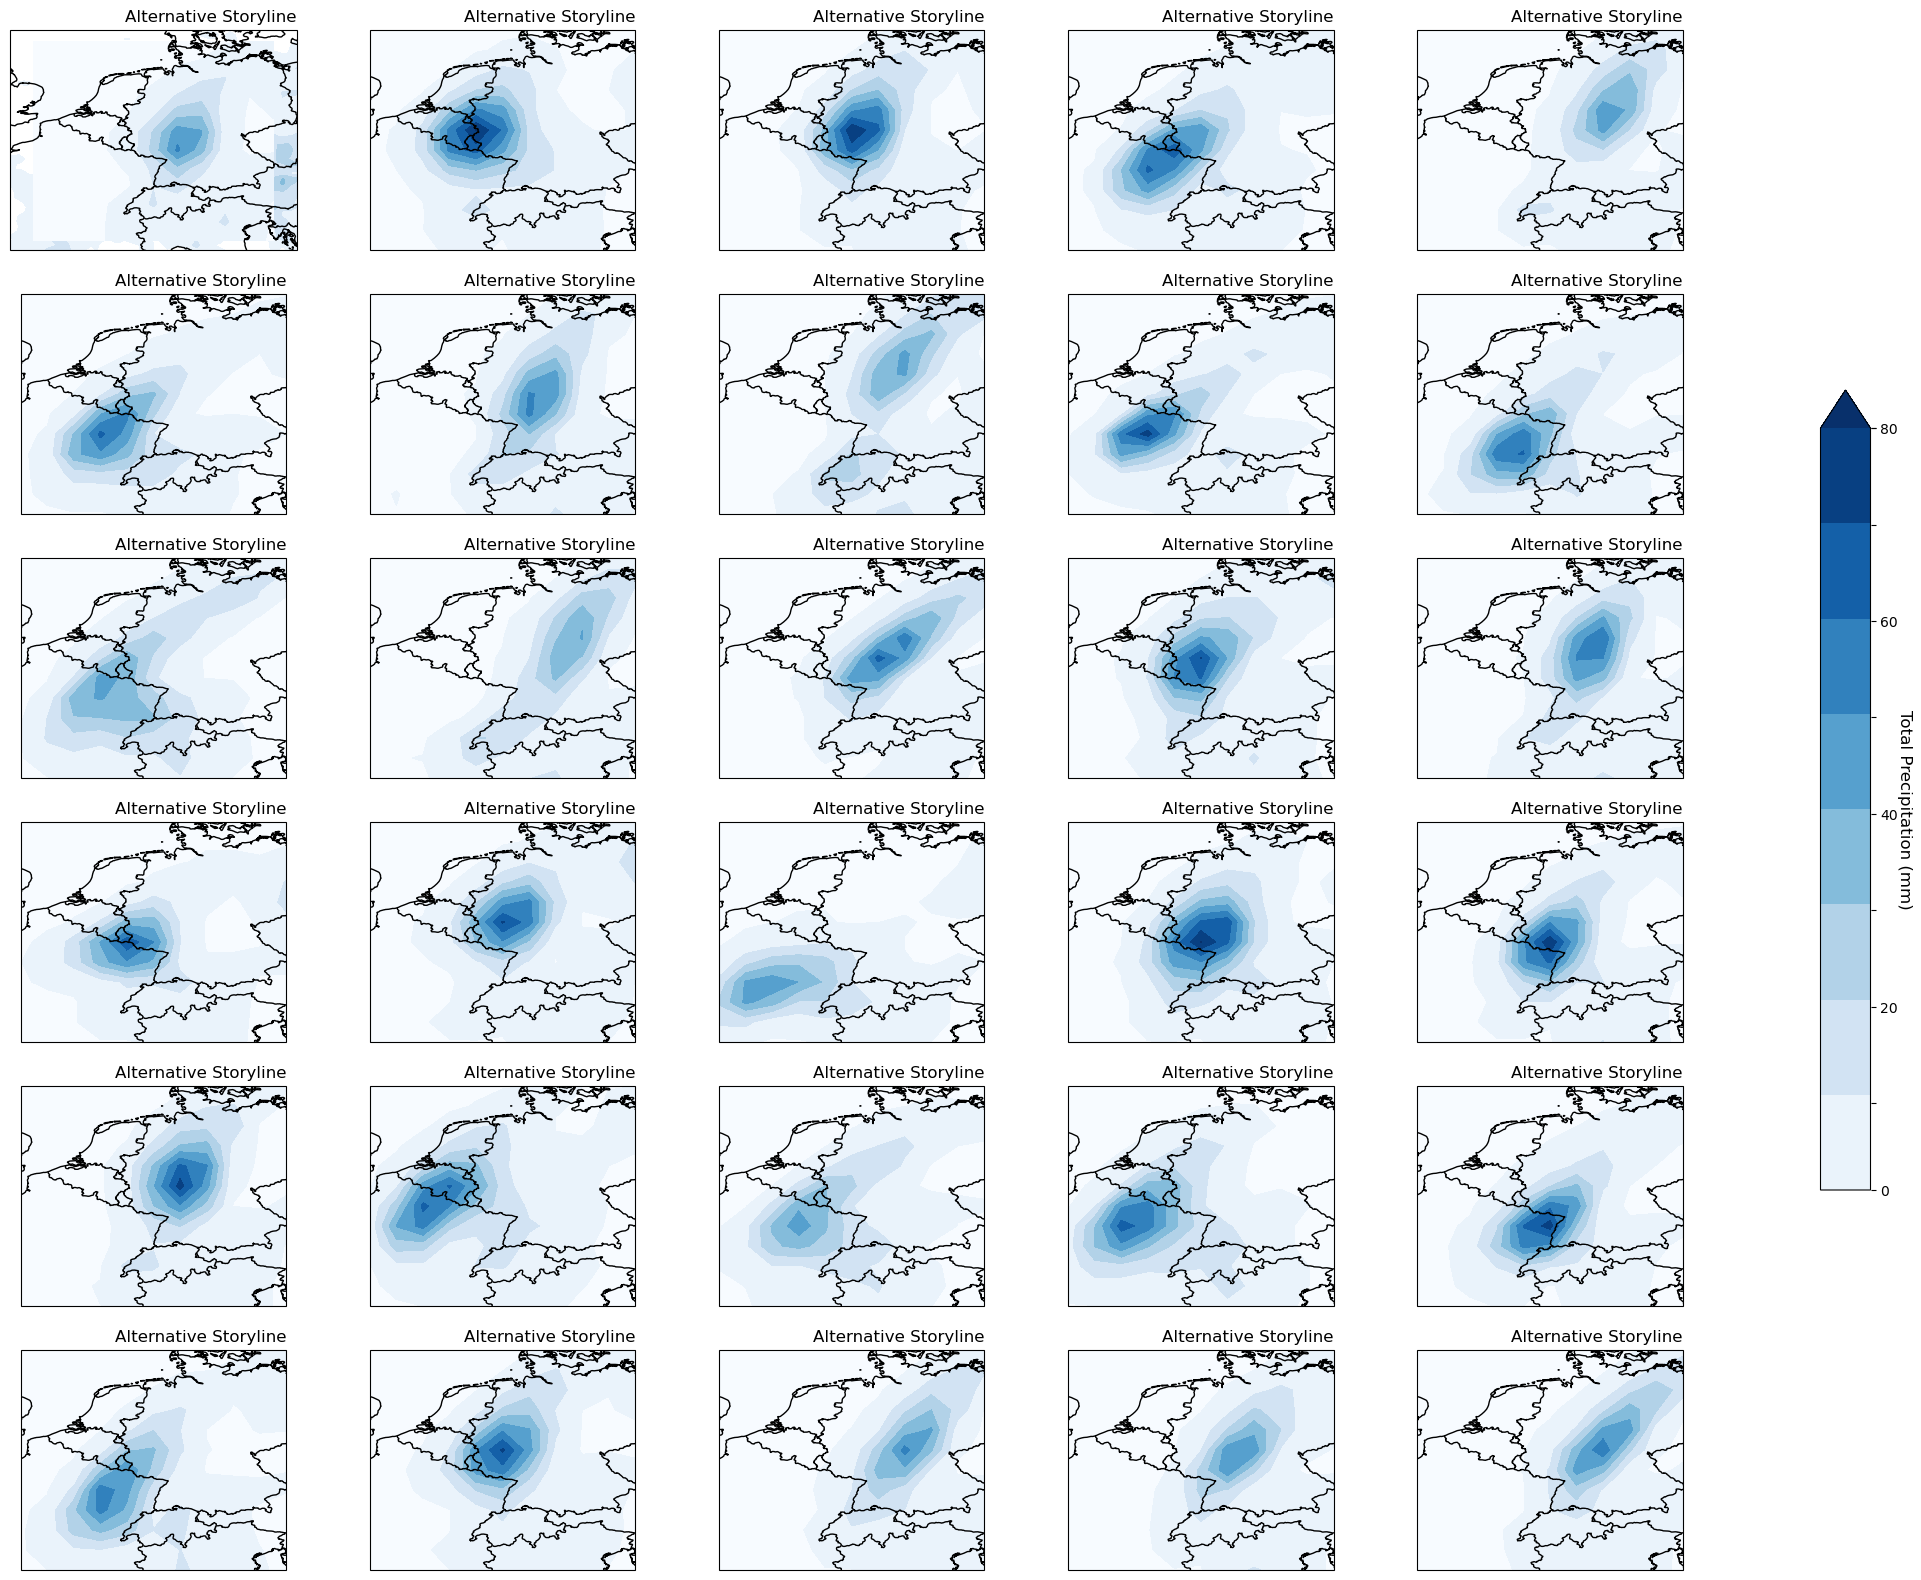

In [28]:
## Event choice supplementary figure
import cartopy.crs as ccrs
import cartopy.feature as c
from matplotlib.transforms import offset_copy
import warnings
warnings.filterwarnings("ignore")

R1 = [56, 44, 15, 0]
fig, axs = plt.subplots(nrows=6, ncols=5, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(25,20))

# Observed event
event_z500 = gdata.var_event_data('z500', R1, date)
event_prec = gdata.var_event_data('tp', R1, date)
lats=event_prec.coord('latitude').points
lons=event_prec.coord('longitude').points
c = axs[0,0].contourf(lons, lats, event_prec.data, levels=np.linspace(1, 80, 9), cmap = plt.cm.get_cmap('Blues'), transform=ccrs.PlateCarree(), extend='max')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.3, 0.02, 0.4])
fig.colorbar(c, cax=cbar_ax, ticks=np.arange(0, 100, 10))
cbar_ax.set_ylabel('Total Precipitation (mm)', labelpad=10, rotation=270, fontsize=12)
cbar_ax.set_yticklabels(['0', '', '20','','40','','60','','80',''])

ax_list = fig.axes
for ens in np.arange(50):
    TP_cube = gboost.get_TP_cube(str(20070814), str(20070825), R1, ens)
    c = ax_list[ens].contourf(TP_cube.coord('longitude').points, TP_cube.coord('latitude').points, TP_cube.data, levels=np.linspace(1, 80, 9), cmap = plt.cm.get_cmap('Blues'), transform=ccrs.PlateCarree(), extend='both')
    ax_list[ens].set_title('Alternative Storyline', loc='right')
    ax_list[ens].add_feature(cf.BORDERS)
    ax_list[ens].add_feature(cf.COASTLINE) 
    #add_cities(ax_list[ens])